In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

from torch.utils.tensorboard import SummaryWriter

from resources.runBuilder import RunBuilder
from collections import OrderedDict
from collections import namedtuple

torch.set_printoptions(linewidth=120)

In [28]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # the first in_channel depends on the number of color channels present in our dataset
        # for gray scale images, like the ones in the mnist dataset, that is one.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        # The 12 in in_features comes from the 12 in out_channels above
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        # out_features is equal to the number of classes in our training set
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)

        # We won't use softmax here because we are going to use the cross_entropy function
        # t = F.softmax(t, dim=1)

        return t

In [29]:
def get_train_set():

    # We're using the FashinMNIST dataset
    train_set = torchvision.datasets.FashionMNIST(
        root='./data'
        ,train=True
        ,download=True
        ,transform=transforms.Compose([
            transforms.ToTensor()
        ])
    )

    return train_set

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [1]:
from itertools import product
import run_manager

In [42]:
# Makes parameters for our RunBuilder class

params = OrderedDict(
    lr = [.01]
    ,batch_size = [1000, 2000]
    ,shuffle = [True]
)

[Run(lr=0.01, batch_size=100), Run(lr=0.01, batch_size=1000), Run(lr=0.001, batch_size=100), Run(lr=0.001, batch_size=1000)]


In [39]:

m = RunManager()
for run in RunBuilder.get_runs(params):

    lr = run.lr or 0.01
    batch_size = run.batch_size or 100
    shuffle = run.shuffle or False


    network = Network()
    train_set = get_train_set()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    m.begin_run(run, network, loader)
    for epoch in range(10):
        m.begin_epoch()
        for batch in train_loader: # Get batch

            images, labels = batch

            preds = network(images) # Pass batch
            loss = F.cross_entropy(preds, labels) # Calcualte loss
            
            optimizer.zero_grad() # Zeros out the gradients before the next calcualtion
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights

            m.track_loss(loss)
            m.track_num_correct(preds, labesls)
        
        m.end_epoch()
        # print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)
        # print("accuracy:", total_correct / len(train_set))
    m.end_run()
m.save('results')

epoch: 0 total_correct: 46807 loss: 36107.849870640785
accuracy: 0.7801166666666667
epoch: 1 total_correct: 48668 loss: 31601.266411747783
accuracy: 0.8111333333333334
epoch: 2 total_correct: 49096 loss: 30658.872516087722
accuracy: 0.8182666666666667
epoch: 3 total_correct: 49041 loss: 30328.95151173463
accuracy: 0.81735
epoch: 4 total_correct: 49071 loss: 31016.139924989548
accuracy: 0.81785
epoch: 5 total_correct: 49288 loss: 30626.542596754152
accuracy: 0.8214666666666667
epoch: 6 total_correct: 49276 loss: 30176.68719941168
accuracy: 0.8212666666666667
epoch: 7 total_correct: 49150 loss: 31154.74623340764
accuracy: 0.8191666666666667
epoch: 8 total_correct: 49469 loss: 30008.745224541053
accuracy: 0.8244833333333333
epoch: 9 total_correct: 49433 loss: 30596.496828427335
accuracy: 0.8238833333333333
epoch: 0 total_correct: 6091 loss: 138301.09542369843
accuracy: 0.10151666666666667
epoch: 1 total_correct: 6084 loss: 138296.9036579132
accuracy: 0.1014
epoch: 2 total_correct: 6084 lo

In [30]:
# Just some code to get some images into tensorboard

tb = SummaryWriter()

network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

In [31]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [9]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
    train_preds = get_all_preds(network, prediction_loader)

In [10]:
train_preds.requires_grad

False

In [11]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print("Total correct predictions:", preds_correct)
print("Accuracy:", preds_correct/len(train_set))

Total correct predictions: 53250
Accuracy: 0.8875


In [12]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim=1)
    )
    , dim=1
)

In [13]:
stacked.shape

torch.Size([60000, 2])

In [14]:
cmt = torch.zeros(10, 10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [15]:
for pred in stacked:
    tl, pl = pred.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [16]:
cmt

tensor([[5305,   24,   92,  108,   15,    1,  364,    0,   91,    0],
        [   5, 5847,    1,  128,    5,    1,    7,    0,    6,    0],
        [  75,    3, 4771,   52,  878,    1,  174,    0,   46,    0],
        [ 185,   28,   20, 5330,  305,    0,   94,    1,   37,    0],
        [   7,    2,  281,  152, 5353,    0,  183,    0,   22,    0],
        [   0,    2,    0,    0,    0, 5851,    0,   91,    5,   51],
        [ 899,   11,  556,  137,  748,    0, 3498,    0,  149,    2],
        [   0,    0,    0,    0,    0,   86,    0, 5502,    1,  411],
        [   4,    1,   13,   16,   32,   13,   23,    4, 5884,   10],
        [   0,    0,    0,    0,    0,   25,    0,   63,    3, 5909]], dtype=torch.int32)

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Local file I've copied to the resources folder
from resources.plotcm import plot_confusion_matrix

In [18]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5305,   24,   92,  108,   15,    1,  364,    0,   91,    0],
       [   5, 5847,    1,  128,    5,    1,    7,    0,    6,    0],
       [  75,    3, 4771,   52,  878,    1,  174,    0,   46,    0],
       [ 185,   28,   20, 5330,  305,    0,   94,    1,   37,    0],
       [   7,    2,  281,  152, 5353,    0,  183,    0,   22,    0],
       [   0,    2,    0,    0,    0, 5851,    0,   91,    5,   51],
       [ 899,   11,  556,  137,  748,    0, 3498,    0,  149,    2],
       [   0,    0,    0,    0,    0,   86,    0, 5502,    1,  411],
       [   4,    1,   13,   16,   32,   13,   23,    4, 5884,   10],
       [   0,    0,    0,    0,    0,   25,    0,   63,    3, 5909]],
      dtype=int64)

Normalized confusion matrix


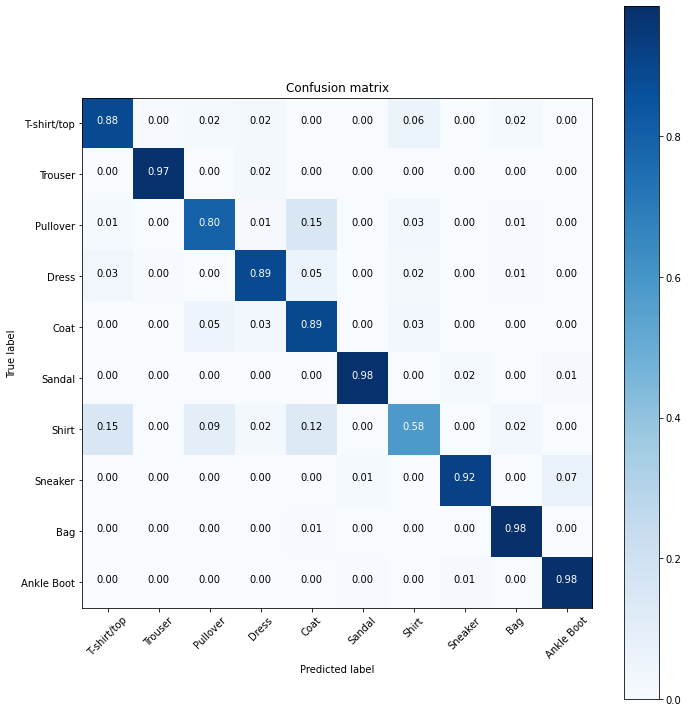

In [19]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, names, normalize=True)